# DMRG TEBD(Time evolution block decimation) for $S = \frac{1}{2}$ 

Edited by [Min Long](https://quantummc.xyz/members/min-long/), November.2023.

This notebook contains the dynamic properties of Heisenberg chian in the formalism of matric product state(MPS).

The idea is that we want to calculate the time dependent evolution of an arbitrary state(Of couse in MPS form), that is $e^{i\hat{H}t}|\psi\rangle$

The initial state $|\psi\rangle$ is prepared and written in MPS form. Then we want to write the time evolution operator in MPO(Matrix product operator form). Once we finish this construction, we can implement the calculation on the fly.

First we prepare the groudstate, this process is copied from the file "DMRG_MPS"

For reference, reader can refer to the good review of Ulrich Schollwoeck [\[ref\]](https://arxiv.org/abs/1008.3477)

## Ground state calculation

In [1]:
import numpy as np
import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse
from time import perf_counter
import numpy.linalg as npla
import matplotlib.pyplot as plt
import copy
import math


## initial E and F matrices for the left and right vacuum states
def initial_E(W):
    E = np.zeros((W.shape[0], 1, 1))
    E[0] = 1
    return E


def initial_F(W):
    F = np.zeros((W.shape[1], 1, 1))
    F[-1] = 1
    return F


def contract_from_right(W, A, F, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,bjl,tkl->aik",W,A,F,B, optimize=True)
    Temp = np.einsum("sij,bjl->sbil", A, F)
    Temp = np.einsum("sbil,abst->tail", Temp, W)
    return np.einsum("tail,tkl->aik", Temp, B)


def contract_from_left(W, A, E, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,aik,tkl->bjl",W,A,E,B, optimize=True)
    Temp = np.einsum("sij,aik->sajk", A, E)
    Temp = np.einsum("sajk,abst->tbjk", Temp, W)
    return np.einsum("tbjk,tkl->bjl", Temp, B)


# construct the F-matrices for all sites except the first
def construct_F(Alist, MPO, Blist):
    F = [initial_F(MPO[-1])]

    for i in range(len(MPO) - 1, 0, -1):
        F.append(contract_from_right(MPO[i], Alist[i], F[-1], Blist[i]))
    return F


def construct_E(Alist, MPO, Blist):
    return [initial_E(MPO[0])]


# 2-1 coarse-graining of two site MPO into one site
def coarse_grain_MPO(W, X):
    return np.reshape(np.einsum("abst,bcuv->acsutv", W, X),
                      [W.shape[0], X.shape[1],
                       W.shape[2] * X.shape[2],
                       W.shape[3] * X.shape[3]])


def product_W(W1, W2):
    return np.reshape(np.einsum("abst,cdtu->acbdsu", W1, W2), [W1.shape[0] * W2.shape[0],
                                                               W1.shape[1] * W2.shape[1],
                                                               W1.shape[2], W2.shape[3]])


def product_MPO(M1, M2):
    assert len(M1) == len(M2)
    Result = []
    for i in range(0, len(M1)):
        Result.append(product_W(M1[i], M2[i]))
    return Result


# 2-1 coarse-graining of two-site MPS into one site
def coarse_grain_MPS(A, B):
    return np.reshape(np.einsum("sij,tjk->stik", A, B),
                      [A.shape[0] * B.shape[0], A.shape[1], B.shape[2]])


def fine_grain_MPS(A, dims):
    assert A.shape[0] == dims[0] * dims[1]
    Theta = np.transpose(np.reshape(A, dims + [A.shape[1], A.shape[2]]),
                         (0, 2, 1, 3))
    M = np.reshape(Theta, (dims[0] * A.shape[1], dims[1] * A.shape[2]))
    U, S, V = np.linalg.svd(M, full_matrices=0)
    U = np.reshape(U, (dims[0], A.shape[1], -1))
    V = np.transpose(np.reshape(V, (-1, dims[1], A.shape[2])), (1, 0, 2))
    # assert U is left-orthogonal
    # assert V is right-orthogonal
    # print(np.dot(V[0],np.transpose(V[0])) + np.dot(V[1],np.transpose(V[1])))
    return U, S, V


def truncate_MPS(U, S, V, m):
    m = min(len(S), m)
    trunc = np.sum(S[m:])
    S = S[0:m]
    U = U[:, :, 0:m]
    V = V[:, 0:m, :]
    return U, S, V, trunc, m


def Expectation(AList, MPO, BList):
    E = [[[1]]]
    for i in range(0, len(MPO)):
        E = contract_from_left(MPO[i], AList[i], E, BList[i])
    return E[0][0][0]


class HamiltonianMultiply(sparse.linalg.LinearOperator):
    def __init__(self, E, W, F):
        self.E = E
        self.W = W
        self.F = F
        self.dtype = np.dtype('d')
        self.req_shape = [W.shape[2], E.shape[1], F.shape[1]]
        self.size = self.req_shape[0] * self.req_shape[1] * self.req_shape[2]
        self.shape = [self.size, self.size]

    def _matvec(self, A):
        # the einsum function doesn't appear to optimize the contractions properly,
        # so we split it into individual summations in the optimal order
        # R = np.einsum("aij,sik,abst,bkl->tjl",self.E,np.reshape(A, self.req_shape),
        #              self.W,self.F, optimize=True)
        R = np.einsum("aij,sik->ajsk", self.E, np.reshape(A, self.req_shape))
        R = np.einsum("ajsk,abst->bjtk", R, self.W)
        R = np.einsum("bjtk,bkl->tjl", R, self.F)
        return np.reshape(R, -1)


## optimize a single site given the MPO matrix W, and tensors E,F
def optimize_site(A, W, E, F):
    H = HamiltonianMultiply(E, W, F)
    # we choose tol=1E-8 here, which is OK for small calculations.
    # to bemore robust, we should take the tol -> 0 towards the end
    # of the calculation.
    E, V = sparse.linalg.eigsh(H, 1, v0=A, which='SA', tol=1E-8)
    return (E[0], np.reshape(V[:, 0], H.req_shape))


def optimize_two_sites(A, B, W1, W2, E, F, m, dir):
    W = coarse_grain_MPO(W1, W2)
    AA = coarse_grain_MPS(A, B)
    H = HamiltonianMultiply(E, W, F)
    E, V = sparse.linalg.eigsh(H, 1, v0=AA, which='SA')
    AA = np.reshape(V[:, 0], H.req_shape)
    A, S, B = fine_grain_MPS(AA, [A.shape[0], B.shape[0]])
    A, S, B, trunc, m = truncate_MPS(A, S, B, m)
    if (dir == 'right'):
        B = np.einsum("ij,sjk->sik", np.diag(S), B)
    else:
        assert dir == 'left'
        A = np.einsum("sij,jk->sik", A, np.diag(S))
    return E[0], A, B, trunc, m
def two_site_dmrg(MPS, MPO, m, sweeps):
    E = construct_E(MPS, MPO, MPS)
    F = construct_F(MPS, MPO, MPS)
    F.pop()
    for sweep in range(0, int(sweeps / 2)):
        for i in range(0, len(MPS) - 2):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'right')
            print("Sweep {:} Sites {:},{:}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"
                  .format(sweep * 2, i, i + 1, Energy, states, trunc))
            E.append(contract_from_left(MPO[i], MPS[i], E[-1], MPS[i]))
            F.pop();
        for i in range(len(MPS) - 2, 0, -1):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'left')
            print("Sweep {} Sites {},{}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"

                  .format(sweep * 2 + 1, i, i + 1, Energy, states, trunc))
            F.append(contract_from_right(MPO[i + 1], MPS[i + 1], F[-1], MPS[i + 1]))
            E.pop();
    return MPS




d = 2  # local bond dimension
N = 41  # number of sites

InitialA1 = np.zeros((d, 1, 1))
InitialA1[0, 0, 0] = 1
InitialA2 = np.zeros((d, 1, 1))
InitialA2[1, 0, 0] = 1

## initial state |01010101>
MPS = [InitialA1, InitialA2] * int(N / 2)
if N%2 != 0 :
    MPS = MPS + [InitialA1]

## Local operators
I = np.identity(2)
Z = np.zeros((2, 2))
Sz = np.array([[0.5, 0],
               [0, -0.5]])
Sp = np.array([[0, 0],
               [1, 0]])
Sm = np.array([[0, 1],
               [0, 0]])

## Hamiltonian MPO
W = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z],
              [Z, Z, Z, Z, Sz],
              [Z, Z, Z, Z, Sm],
              [Z, Z, Z, Z, Sp],
              [Z, Z, Z, Z, I]])

Wfirst = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z]])

Wlast = np.array([[Z], [Sz], [Sm], [Sp], [I]])

# the complete MPO
MPO = [Wfirst] + ([W] * (N - 2)) + [Wlast]

HamSquared = product_MPO(MPO, MPO)

D = 10
# 6 sweeps with m=10 states
MPS = two_site_dmrg(MPS, MPO, D, 6)

Sweep 0 Sites 0,1    Energy -10.309016994375    States    2 Truncation   0.000000000000
Sweep 0 Sites 1,2    Energy -10.439692620786    States    2 Truncation   0.000000000000
Sweep 0 Sites 2,3    Energy -10.645800958670    States    2 Truncation   0.000000000000
Sweep 0 Sites 3,4    Energy -10.810586239348    States    2 Truncation   0.000000000000
Sweep 0 Sites 4,5    Energy -10.993669962857    States    2 Truncation   0.000000000000
Sweep 0 Sites 5,6    Energy -11.167602338044    States    2 Truncation   0.000000000000
Sweep 0 Sites 6,7    Energy -11.345754582728    States    2 Truncation   0.000000000000
Sweep 0 Sites 7,8    Energy -11.521867353000    States    2 Truncation   0.000000000000
Sweep 0 Sites 8,9    Energy -11.698938381096    States    2 Truncation   0.000000000000
Sweep 0 Sites 9,10    Energy -11.875551828355    States    2 Truncation   0.000000000000
Sweep 0 Sites 10,11    Energy -12.052381755193    States    2 Truncation   0.000000000000
Sweep 0 Sites 11,12    Energy

## Benchmark of ground state
Above code perform ground state searching using 2-sites DMRG, detailed explanation can be refered in the DMRG_MPS notebook,  before proceeding to time evolution, we benchmark our ground state and implement some basic operations we will perform on MPS.

We want to measure the correlation function $\langle S(x)S(0)\rangle$ for ground state, we already know that this correlation funtion is expotentially decay. Due to the antiferremagnetic ground state, the correlation function also bear the feature that it is oscillating beteen the positive and negative value.

Below I implement some basic function which perform measurement and inner product of MPS.

Reader should already familiar with these operations from the practice of ground state searching using MPS formalism.



################################################################
#                   Benchmark of groundstate                   #
################################################################
Final energy expectation value -17.96171179834177
variance =   0.002753960244


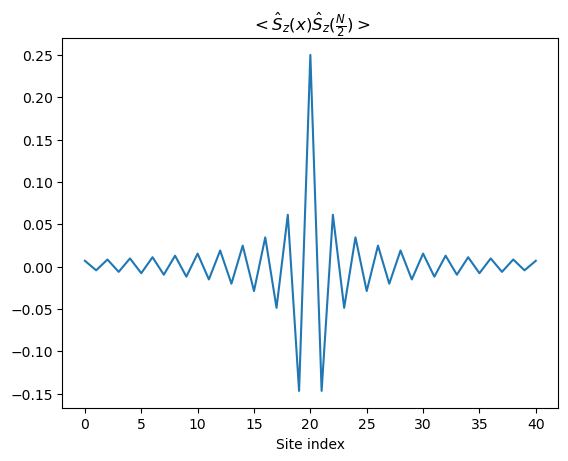

In [2]:

print('\n')
print(
    "################################################################\n"
    "#                   Benchmark of groundstate                   #\n"
    "################################################################"
)

Energy = Expectation(MPS, MPO, MPS)
print("Final energy expectation value {}".format(Energy))

H2 = Expectation(MPS, HamSquared, MPS)
print("variance = {:16.12f}".format(H2 - Energy * Energy))

Gs = copy.deepcopy(MPS)

def state_overlap(Co_List,Contro_List):
    R = [[1]]
    for i in range(0, len(Co_List)):
        R = np.einsum("ik,sij->skj",R,Co_List[i])
        R = np.einsum("skj,skl->jl",R,Contro_List[i].conjugate())
    return R[0][0]


def multi_site_measurement(MPS1,MPS2,op_list,pos_list):
    idx = np.argsort(pos_list)
    pos_list = np.array(pos_list)[idx]
    op_list = np.array(op_list)[idx]
    expectation = [[1]]
    # print(op_list,pos_list)
    assert len(op_list) == len(pos_list)
    for j in range(0, pos_list[0]):
        expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
        expectation = np.einsum("skj,skl->jl",  expectation,MPS2[j].conjugate())
    expectation = np.einsum('ik,sij,st,tkl->jl', expectation, MPS1[pos_list[0]], op_list[0], MPS2[pos_list[0]].conjugate())
    for i in range(len(op_list)-1):
        for j in range(pos_list[i]+1,pos_list[i+1]):
            expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
            expectation = np.einsum("skj,skl->jl", expectation,MPS2[j].conjugate())
        expectation = np.einsum('ik,sij,st,tkl->jl', expectation, MPS1[pos_list[i+1]], op_list[i+1], MPS2[pos_list[i+1]].conjugate())
    for j in range(pos_list[-1]+1,len(MPS1)):
        expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
        expectation = np.einsum("skj,skl->jl", expectation,MPS2[j].conjugate())
    return expectation[0][0]


def plot_Sz_correlaion_MPS(MPS_in):
    Sz_correlation = []
    for i in range(N):
        if i != N//2:
            Sz_correlation.append(multi_site_measurement(MPS_in,Gs,[Sz,Sz],[i,N//2]))
        else:
            Sz_correlation.append(multi_site_measurement(MPS_in, Gs, [Sz@Sz], [i]))
    plt.plot(Sz_correlation)
    plt.title(r"$<\hat{S}_z(x)\hat{S}_z(\frac{N}{2})>$")
    plt.xlabel("Site index")
    # plt.savefig("temp")
    plt.show()
    # plt.savefig("Sz_correlation_measurement")
    plt.close()
plot_Sz_correlaion_MPS(Gs)
# quit()


## Transfer of singular values.

In practice, we usually use mix caconical form to do calculation. The advantage of this form is that it is convinient to do truncation according to the singular values.

Physically, the trancation at a site makes sense when all the left sites are of the left caconical form and all the right sites are of the right caconical form. Since in such case the MPS can be view as combination of orthogonal states, which are the direct product of states from left subsystem and right subsystem. That is:
$$
|\Psi\rangle = \sum_i s_i |a_i\rangle | b_i\rangle
$$  

Then the truncation has clear physical meaning: We neglect the components which constitute small part of the total state.

Since everytime we do measurement or acting operators, there is possibility of bringing singular values. We have to move the mix caconical site to the site where we will operate to absorb the singular value.

**Below is an illustration on how to transfer singular values.**

Initially, singular value is stored in $M_{a_1 a_2}^{\sigma_2}$

1. Reshape $M_{a_1 a_2}^{\sigma_2}$ into a matrix with the form $M_{(\sigma_1a_1),a_2}$, where $(\sigma_1a_1)$ is a composite index which has the dimenstion $Dim(\sigma_1)\times Dim(a_1)$ .
2. Perform SVD on the matrix, then it turns to $U_{(\sigma_1a_1),a_i}S_{a_i,a_j}V_{a_j,a_2}$.
3. From the basic properties of SVD, $A^{\sigma_1}_{a_1a_i} = U_{(\sigma_1a_1),a_i}$ is a left caconical matrix. We keep A in site 1.
4. Absorb S and V to $B^{\sigma_2}_{a_2a_3}$

Then the singular value transfer of between adjacent sites has been finished, for transfer more that one site, just do it interatively.

![image.png](https://github.com/DavidGoing/DMRG/raw/main/figures/TEBD_moving_singular_values.png)

In [3]:

# print("\n")
# print(
# "############################################################################\n\
# #                    Time evolution of Ground state using iTEBD            # \n\
# ############################################################################"
# )

def move_mix_site(start ,end , mix_MPS ,bond_dim):
    if end > start:
        move_dir = 'r'
        for i in range(start,end,1):
            M1 = mix_MPS[i]
            M_mat = np.reshape(M1,(M1.shape[0]*M1.shape[1],M1.shape[2]))
            A, S, B = np.linalg.svd(M_mat, full_matrices=0)
            trunc_dim = min(bond_dim,len(S))
            A = A[:,0:trunc_dim]
            S = S[0:trunc_dim]
            B = B[0:trunc_dim,:]
            # print(npla.norm(A@np.diag(S)@B-M_mat))
            trunc = np.sum(S[trunc_dim:])
            A = np.reshape(A,(M1.shape[0],M1.shape[1],-1))
            # print("Truncation error in moving from site {} to {} : {}".format(i,i+1,trunc))
            if trunc > 1e-10:
                raise Exception("large truncation error")
            B = np.diag(S)@B
            mix_MPS[i] =  A
            mix_MPS[i+1] = np.einsum("ij,sjk->sik",B,mix_MPS[i+1])
    if end < start:
        move_dir = 'l'
        for i in range(start,end,-1):
            M1 = mix_MPS[i]
            M_mat = np.reshape(M1.transpose(1,0,2), (M1.shape[1], M1.shape[0] * M1.shape[2]))
            A, S, B = np.linalg.svd(M_mat, full_matrices=0)
            trunc_dim = min(bond_dim, len(S))
            A = A[:, 0:trunc_dim]
            S = S[0:trunc_dim]
            B = B[0:trunc_dim, :]
            # print(npla.norm(A @ np.diag(S) @ B - M_mat))
            trunc = np.sum(S[trunc_dim:])
            B = np.reshape(B, (-1,M1.shape[0], M1.shape[2])).transpose(1,0,2)
            # print("Truncation error in moving from site {} to {} : {}".format(i, i + 1, trunc))
            if trunc > 1e-10:
                raise Exception("large truncation error")
            A = A@np.diag(S)
            mix_MPS[i] = B
            mix_MPS[i - 1] = np.einsum("sjk,kl->sjl", mix_MPS[i-1], A)
    if "move_dir" not in locals():
        raise Exception("Not standard input form, Nothing happend")
    return mix_MPS

def check_othogonal(MPS):
    infor_string = []
    for ten in MPS:
        matl = np.einsum("sij,sik->jk",ten,ten)
        matr = np.einsum("sij,slj->il",ten,ten)
        dim = matl.shape[0]
        Il = np.identity(dim)
        Ir = np.identity(matr.shape[0])
        if npla.norm(matl-Il)<1e-10:
            infor_string.append('A')
        if npla.norm(matr-Ir)<1e-10:
            infor_string.append('B')
        if not(npla.norm(matl-Il)<1e-10 or npla.norm(matr-Ir)<1e-10):
            infor_string.append('M')
    return ' '.join(infor_string)



In [4]:


print("Normalizatin check of Ground state",state_overlap(Gs,Gs))

tau =0.02 # 0.02
time_slice = 600 # 600
Evolution_Sz = np.zeros((time_slice+1,N),dtype=complex)
Correlaion_SpSm = np.zeros((time_slice+1,N),dtype=complex)

MPSt = copy.deepcopy(Gs)


# t = 0 , do Sz measurement
# MPSt = null_two_site_dmrg(MPSt,MPO,D,8)




print("\n")
print(
    "##################################################\n"
    "#      Time evolution and perform measurement    #\n"
    "##################################################"
)



def orthogonize(M,bond_dim):
    M1 = copy.deepcopy(M)
    M_mat = np.reshape(M1, (M1.shape[0] * M1.shape[1], M1.shape[2]))
    A, S, B = np.linalg.svd(M_mat, full_matrices=0)
    trunc_dim = min(bond_dim, len(S))
    A = A[:, 0:trunc_dim]
    S = S[0:trunc_dim]
    B = B[0:trunc_dim, :]
    S = np.array(S)/np.sqrt(sum([abs(item)**2 for item in S]))
    M_mat = np.reshape(A@ np.diag(S) @B, (M1.shape[0] , M1.shape[1], M1.shape[2]))
    return M_mat

MPSt = move_mix_site(start=1,end=N//2, mix_MPS=MPSt,bond_dim=D)
MPSt[N//2] = np.einsum("sij,st->tij",MPSt[N//2],Sp)
MPSt[N//2] = orthogonize(MPSt[N//2],D)
MPSt = move_mix_site(start=N//2,end=1, mix_MPS=MPSt,bond_dim=D)


Normalizatin check of Ground state 1.0000000000000095


##################################################
#      Time evolution and perform measurement    #
##################################################


## Time evolution

Every time step we calculate $e^{i\hat{H}\tau}$(This will bring a Trotter error proportional to $\tau$), where $\tau$ is the time step.

$$
e^{i\hat{H}\tau} = \prod_{i = 0}^{i=L-1} e^{i\tau(\hat{S_i}\hat{S_{i+1}})} + O(\tau)
$$

Where $O(\tau)$ is the error bring by the commutator.

In calculating every block we move on the singular values.

![image.png](https://github.com/DavidGoing/DMRG/raw/main/figures/TEBD_block_absorption.png)

In [5]:


print('############################')

start = perf_counter()
for i in range(N):
    Evolution_Sz[0,i] = multi_site_measurement(MPSt,MPSt,[Sz],[i])
    Correlaion_SpSm[0,i] = multi_site_measurement(MPSt,Gs,[Sm],[i])


Coupled_operator = np.einsum("st,kl-> sktl",Sz,Sz)
Coupled_operator += 0.5*np.einsum("st,kl-> sktl",Sp,Sm)
Coupled_operator += 0.5*np.einsum("st,kl-> sktl",Sm,Sp)
Exp_Coupled = np.reshape(Coupled_operator,(4,4))
Exp_Coupled = scipy.linalg.expm(complex(0,tau)*Exp_Coupled)

for t in range(time_slice//2):
    for i in range(0,N-1,1):
        MM = coarse_grain_MPS(MPSt[i], MPSt[i+1])
        image = np.einsum("st,sij->tij",Exp_Coupled,MM)
        A, S, B = fine_grain_MPS(image, [MPSt[i].shape[0], MPSt[i + 1].shape[0]])
        A, S, B, trunc, m = truncate_MPS(A, S, B, D)
        # print(trunc)
        B = np.einsum("ij,sjk->sik",  np.diag(S),B)
        MPSt[i], MPSt[i + 1]  = A,B
    for i in range(N):
        Evolution_Sz[t*2+1 , i] = multi_site_measurement(MPSt,MPSt,[Sz],[i])
        Correlaion_SpSm[t*2+1 , i] = multi_site_measurement(MPSt,Gs,[Sm],[i])
    # for i in range(N//2+1):
    #     sz_val = multi_site_measurement(MPSt,MPSt,[Sz],[i+N//2])
    #     spsm_val = multi_site_measurement(MPSt,Gs,[Sm],[i+N//2])
    #     Evolution_Sz[t*2+1 , N//2+i] = sz_val
    #     Evolution_Sz[t*2+1 , N//2-i] = sz_val
    #     Correlaion_SpSm[t*2+1 , N//2+i] = spsm_val
    #     Correlaion_SpSm[t*2+1 , N//2-i] = spsm_val
    for i in range(N-1,0,-1):
        MM = coarse_grain_MPS(MPSt[i-1], MPSt[i ])
        image = np.einsum("st,sij->tij", Exp_Coupled, MM)
        A, S, B = fine_grain_MPS(image, [MPSt[i-1].shape[0], MPSt[i ].shape[0]])
        A, S, B, trunc, m = truncate_MPS(A, S, B, D)
        # print(trunc)
        A = np.einsum("sij,jk->sik", A, np.diag(S))
        MPSt[i - 1],MPSt[i ] = A,B
    for i in range(N):
        Evolution_Sz[2*t+2 , i] = multi_site_measurement(MPSt,MPSt,[Sz],[i])
        Correlaion_SpSm[2*t+2 , i] = multi_site_measurement(MPSt,Gs,[Sm],[i])
    # for i in range(N//2+1):
    #     sz_val = multi_site_measurement(MPSt,MPSt,[Sz],[i+N//2])
    #     spsm_val = multi_site_measurement(MPSt,Gs,[Sm],[i+N//2])
    #     Evolution_Sz[t*2+2 , N//2+i] = sz_val
    #     Evolution_Sz[t*2+2 , N//2-i] = sz_val
    #     Correlaion_SpSm[t*2+2 , N//2+i] = spsm_val
    #     Correlaion_SpSm[t*2+2 , N//2-i] = spsm_val
end = perf_counter()
print('time used in time evolution: {:.2f}s'.format(end-start))



############################
time used in time evolution: 48.62s


Time evolution of Ground state after adding a excitation. In another word,
$$
|\Psi\rangle = S^+(\frac{L}{2})|Gs\rangle
$$
$|\Psi(t) = e^{i\hbar\hat{H}}|\Psi\rangle$, we want to measure:
$$
S^z(t,x) = \langle \Psi(t)| S^z(x)|\Psi(t)\rangle
$$
We can see the linear dispersion of the spin wave.

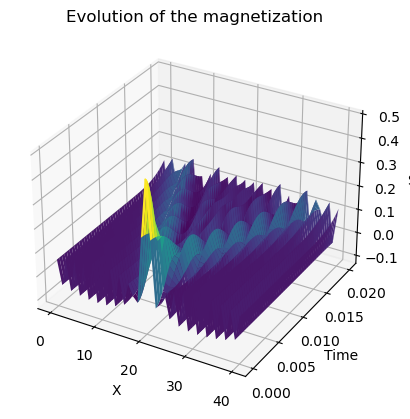

In [6]:

X = np.outer(np.linspace(0, N - 1, N), np.ones(time_slice + 1))
T = np.outer(np.ones(N), np.linspace(0, tau, time_slice + 1))
SzMatrix = np.transpose(np.array(Evolution_Sz).real)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, SzMatrix, cmap='viridis', edgecolor='none')
ax.set_xlabel("X")
ax.set_ylabel("Time")
ax.set_zlabel("Sz")
ax.set_title('Evolution of the magnetization')
plt.show()
plt.close()
# fig.savefig("Evolution of the magnetization_me")


The Spectrum is defined as:
$$
S(\omega,k) = \int\int dx dt e^{ikx} e^{i\omega t} \langle S^-(x,t)S^+(\frac{L}{2},0) \rangle
$$

To improve the result, you can try to add a gaussian window while doing Fourier transform.

In [7]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["font.weight"] = "normal"
# plt.rcParams['xtick.fontfamily'] = 'bold'
# plt.rcParams['ytick.fontfamily'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'bold'

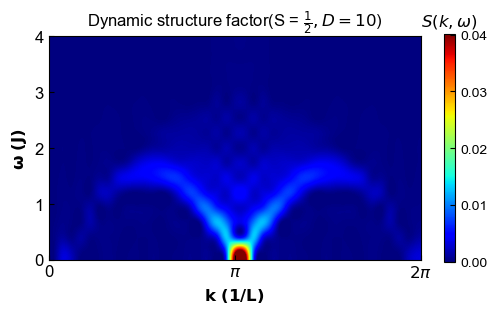

In [35]:
phase_factor = [np.exp(Energy*1j*tau*i) for i in range(-time_slice,time_slice+1)]

Correlation = np.transpose(np.array(Correlaion_SpSm))
Correlation = np.concatenate((np.flip(Correlation[:, 1:].conjugate(), axis=1), Correlation), axis=1)
Correlation = Correlation @ np.diag(phase_factor)
Spec = np.absolute(np.fft.fft2(Correlation))
Spec = Spec/np.size(Spec)
# Spec = Spec[:, 68:52:-1] 
Spec = Spec[:, 1065:1080]
# Spec = Spec[:,0:50]
NumOmega = np.shape(Spec)[1]
K = np.outer(np.linspace(0, np.pi * 2, N), np.ones(NumOmega))
W = np.outer(np.ones(N), np.linspace(0, NumOmega * np.pi / (tau * time_slice), NumOmega))


fig, ax = plt.subplots()



im = ax.imshow(abs(Spec).T, interpolation='Spline36', cmap="jet",
               origin='lower', extent=[0,10,0,6],
               vmax=abs(Spec).max(), vmin=0)
# cbar = plt.colorbar()
plt.xticks([0,5,10],['0',r"$\pi$",r"$2\pi$"],fontsize = 12)
plt.xlabel(r'$\mathbf{k \ (1/L)}$',fontsize = 12)
plt.yticks([0,1.5,3,4.5,6],[0,1,2,3,4],fontsize = 12)
plt.ylabel(r'$\mathbf{\omega \ (J)}$',fontsize = 12)
cbar = fig.colorbar(im, ax=ax,shrink = 0.74)
# cbar.set_label(r'$S(k,\omega)$')
cbar.ax.set_title(r'$S(k,\omega)$')
# cbar.ax.yaxis.set_label_coords(5.4, 0.5)
# cbar.ax.yaxis.label.set_rotation(270)

ax.set_title(r'Dynamic structure factor(S = $\frac{1}{2},D = 10$)')
plt.show()
